In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn import cross_validation
import seaborn as sns

# Any results you write to the current directory are saved as output.

In [2]:
train_data = pd.read_csv('train.csv')
pd.options.display.max_rows = 999
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Number of outcome classes
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

From the number of classess and their proportion, we can see that it is a binary classification problem with imbalanced category. Therefore, we need to consider using f1-score as the evalution metric

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# Combine training and testing data together
data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [61]:
# Make a copy oof original data for testing the preprocessing algorithm
data_rd1 = data.copy()

Given that test data has lots of NaN values in cabin. We will drop this feature.

In [1745]:
data_rd1.drop(labels='Cabin', axis=1, inplace=True)
data_rd1.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [9]:
# Create function for extracting information from Name
import re
import string
def name_parsing(text):
    # Remove bracket content
    title = []
    middle_name = []
    last_name = []
    
    title_bank = ['Miss', 'Mr', 'Mrs', 'Dr', 'Master', 'Major', 'Rev', 'Capt', 'Lady',
       'Mme', 'Ms', 'Col', 'Mlle']
    
    for i in range(len(text)):
        # Remove the content in bracket
        text.iloc[i] = re.sub("[\(\[].*?[\)\]]", "", text.iloc[i])
        # Remove punctuation
        translation = text.iloc[i].maketrans("","", string.punctuation)
        # Split
        # ext_trans = text[i].translate(translation)
        text_split = text.iloc[i].split()
        lastname_flag = 0
        title_flag = 0
        for j in range(len(text_split)):
            if (',' in text_split[j]) & (lastname_flag == 0):
                last_name.append(text_split[j].translate(translation))
                last_name_flag = 1
            
            if ('.' in text_split[j]) & (title_flag == 0):
                title.append(text_split[j].translate(translation))                
                title_flag = 1                
    
        if last_name_flag == 0:
            last_name.append(np.nan)
        
        if title_flag == 0:
            title.append(np.nan)
            
        # first_name.append(text_split[-2].translate(translation))
        middle_name.append(text_split[-1].translate(translation))
        
    return pd.Series(title), pd.Series(last_name), pd.Series(middle_name)

In [10]:
title, last, middle = name_parsing(data_rd1['Name'])

In [62]:
name_type = title.unique()
name_map = {}

for i in range(len(name_type)):
    name_map[name_type[i]] = i

title_name_num = title.map(name_map)
data_rd1['title_name'] = list(title)

In [63]:
data_rd1.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title_name
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [64]:
# To many categorical values for titles, try combining them and apply one hot
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr          57.830405
Miss        19.862490
Mrs         15.049656
Master       4.660046
Rev          0.611154
Dr           0.611154
Col          0.305577
Ms           0.152788
Mlle         0.152788
Major        0.152788
Mme          0.076394
Jonkheer     0.076394
Lady         0.076394
Dona         0.076394
Sir          0.076394
Countess     0.076394
Don          0.076394
Capt         0.076394
Name: title_name, dtype: float64

In [65]:
# Map title name to represent better the gender and ages
title_map = {"Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"}

In [66]:
data_rd1['title_name'] = data_rd1['title_name'].map(title_map)
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr         57.874618
Miss       20.030581
Mrs        15.290520
Master      4.663609
Officer     1.758410
Royalty     0.382263
Name: title_name, dtype: float64

In [68]:
one_hot_title = pd.get_dummies(data_rd1['title_name'])
data_rd1 = data_rd1.join(one_hot_title)
data_rd1.drop(labels='title_name', axis=1, inplace=True)
data_rd1.drop(labels='Name', axis=1, inplace=True)

In [72]:
data_rd1.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,A/5 21171,0,0,1,0,0,0
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,PC 17599,0,0,0,1,0,0
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,0,1,0,0,0,0
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,113803,0,0,0,1,0,0
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,373450,0,0,1,0,0,0


In [73]:
# Extract string and number information from ticket
ticket_ori = data_rd1['Ticket']

ticket_num1 = []
ticket_num2 = []
ticket_str = []
for tk in range(len(ticket_ori)):
    if len(re.findall(r'\d+', ticket_ori.iloc[tk])) ==0:
        ticket_num1.append(np.nan)
        ticket_num2.append(np.nan)
    else:
        ticket_num_temp = re.findall(r'\d+', ticket_ori.iloc[tk])
        if len(ticket_num_temp)>1:
            ticket_num1.append(np.int(ticket_num_temp[0]))
            ticket_num2.append(np.int(ticket_num_temp[-1]))
        else:
            ticket_num1.append(0)
            ticket_num2.append(np.int(ticket_num_temp[-1]))
        
    if len(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))==0:
        ticket_str.append(np.nan)
    else:
        ticket_str.append(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))
        

In [19]:
# data_rd1=data_rd1.join(pd.Series(ticket_str, name='ticket_str'), how='outer')
# data_rd1.drop(labels='ticket_str', axis=1, inplace=True)

In [74]:
data_rd1=data_rd1.join(pd.Series(ticket_num1, name='ticket_num1'), how='outer')
data_rd1=data_rd1.join(pd.Series(ticket_num2, name='ticket_num2'), how='outer')
data_rd1.drop(labels='Ticket', axis=1, inplace=True)

In [75]:
# Use mapping function to convert Sex into binary digits
data_rd1['Sex'] = data_rd1['Sex'].map({'female':1, 'male':0})

In [76]:
data_rd1.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2
0,22.0,NaN,S,7.2500,0,1,3,0,1,0.0,0,0,1,0,0,0,5.0,21171.0
1,38.0,C85,C,71.2833,0,2,1,1,1,1.0,0,0,0,1,0,0,0.0,17599.0
2,26.0,NaN,S,7.9250,0,3,3,1,0,1.0,0,1,0,0,0,0,2.0,3101282.0
3,35.0,C123,S,53.1000,0,4,1,1,1,1.0,0,0,0,1,0,0,0.0,113803.0
4,35.0,NaN,S,8.0500,0,5,3,0,0,0.0,0,0,1,0,0,0,0.0,373450.0


After pre-processing the data into format that we could start analying, we need to look for the univariate and multivariate statistical properties. Our goal is mostly to accopmlist:
1. Remove redundancy and collinearity, which will help feature selection
2. Help filling nan values

Before we start looking into the pattern, we should brain storm what might be the potential complication for each feature, and what factor might influence it and how we could observe and purify the data. We could devide the feature into the critical one, and uncertain one. From the experience, Fare, Age, and Sex are the ones we have to keep. Pclass currently is ambigious. We will use other information to facilite filling and purifying the three features. 
1. Fare: It should represent fare of a single person, that represent the social class. We need to look into whether the current entry represent fare of the single person, and not influenced by where they embark. It could be helped potentially from Parch, SibSp, ticket_num1, ticket_num2. We should look into the correlation with Pcalss after the processing
2. Age: It should represent age of the passenger. However, we need to fill the nan value. It could be helped potentially from fare, Parch, SibSp, Master, Miss, Mr, Mrs

In [77]:
data_rd2 = data_rd1.copy()

In [78]:
# Create dataframe focusing on Fare
df_fare = pd.concat([data_rd2['Fare'], data_rd2['ticket_num1'], data_rd2['ticket_num2'], data_rd2['Parch'], data_rd2['SibSp']], axis=1, keys=['Fare', 'ticket_num1', 'ticket_num2', 'Parch', 'SibSp'])

In [79]:
df_fare.sort_values(by='ticket_num2').head()

,Fare,ticket_num1,ticket_num2,Parch,SibSp
1077,21.00,0.0,2.0,1,0
1193,21.00,0.0,2.0,1,0
841,10.50,0.0,3.0,0,0
772,10.50,0.0,3.0,0,0
1061,7.55,0.0,251.0,0,0


From the above results we can see that 
1. For majority of the cases where passengers share the ticket_num2, they share Fare. This indicates that Fare could be the total fare paid by passengers share the ticket_num2
2. Patch and SibSp could not acurately represent the group number, but could be used in combinaiton with Age to indicate wheter he/she serves as parent, children of neither. 
#### Will comback to this in next round

In [80]:
# Obtain the final fare for dividing the number of occurence
value_occ = pd.Series(df_fare['ticket_num2'].value_counts())
value_occ_single = []
for i in range(len(df_fare)):
    value_occ_tmp = df_fare.iloc[i]['ticket_num2']
    if np.isnan(value_occ_tmp):
        value_occ_single.append(1)
    else:
        # Confirm whether fare are shared across passengers with the same ticket number
        fare_tmp = df_fare.loc[df_fare['ticket_num2'] == value_occ_tmp, 'Fare']
        if len(fare_tmp.value_counts()) == 1:
            value_occ_single.append(value_occ[value_occ_tmp])
        else:
            value_occ_single.append(1)

In [81]:
df_fare = df_fare.join(pd.Series(value_occ_single, name='occurance'), how='outer')

In [82]:
df_fare.sort_values(by='ticket_num2').head()

,Fare,ticket_num1,ticket_num2,Parch,SibSp,occurance
1077,21.00,0.0,2.0,1,0,2
1193,21.00,0.0,2.0,1,0,2
841,10.50,0.0,3.0,0,0,2
772,10.50,0.0,3.0,0,0,2
1061,7.55,0.0,251.0,0,0,1


In [83]:
df_fare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 6 columns):
Fare           1308 non-null float64
ticket_num1    1305 non-null float64
ticket_num2    1305 non-null float64
Parch          1309 non-null int64
SibSp          1309 non-null int64
occurance      1309 non-null int64
dtypes: float64(3), int64(3)
memory usage: 71.6 KB


In [84]:
# Find the fill the nan values of fare before processing
df_fare[np.isnan(df_fare['Fare'])]

,Fare,ticket_num1,ticket_num2,Parch,SibSp,occurance
1043,NaN,0.0,3701.0,0,0,1


In [85]:
# Look to see if there is any enter with shared ticket_num2
df_fare.loc[df_fare['ticket_num2'] == df_fare.iloc[1043]['ticket_num2']]

,Fare,ticket_num1,ticket_num2,Parch,SibSp,occurance
1043,NaN,0.0,3701.0,0,0,1


In [86]:
# Look into the entry with more information in data_rd2
data_rd2.iloc[1043]

Age            60.5
Cabin           NaN
Embarked          S
Fare            NaN
Parch             0
PassengerId    1044
Pclass            3
Sex               0
SibSp             0
Survived        NaN
Master            0
Miss              0
Mr                1
Mrs               0
Officer           0
Royalty           0
ticket_num1       0
ticket_num2    3701
Name: 1043, dtype: object

In [87]:
# Fetch entries with similar informaiton to fill the na
fill_fare = data_rd2.loc[(data_rd2['Age'] > 55)&(data_rd2['Embarked'] =='S')&(data_rd2['Pclass'] ==3)&(data_rd2['Mr'] ==1), 'Fare'].mean()

In [88]:
df_fare.iloc[1043] = df_fare.iloc[1043].fillna(fill_fare)

In [89]:
df_fare['Fare_div'] = df_fare['Fare']/df_fare['occurance']

In [90]:
# data_rd2.drop('Fare', axis=1, inplace=True)
data_rd2 = data_rd2.join(df_fare['Fare_div'], how='outer')
data_rd2 = data_rd2.join(df_fare['occurance'], how='outer')
data_rd2.drop('Fare', axis=1, inplace=True)
data_rd2 = data_rd2.join(df_fare['Fare'], how='outer')

In [107]:
data_rd3 = data_rd2.copy()

In [108]:
data_rd3.head()

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Fare_div,occurance,Fare
0,22.0,NaN,S,0,1,3,0,1,0.0,0,0,1,0,0,0,5.0,21171.0,7.25000,1.0,7.2500
1,38.0,C85,C,0,2,1,1,1,1.0,0,0,0,1,0,0,0.0,17599.0,35.64165,2.0,71.2833
2,26.0,NaN,S,0,3,3,1,0,1.0,0,1,0,0,0,0,2.0,3101282.0,7.92500,1.0,7.9250
3,35.0,C123,S,0,4,1,1,1,1.0,0,0,0,1,0,0,0.0,113803.0,26.55000,2.0,53.1000
4,35.0,NaN,S,0,5,3,0,0,0.0,0,0,1,0,0,0,0.0,373450.0,8.05000,1.0,8.0500


Look into the relationship between Embarked and Fare given Pclass

In [109]:
fare_em = pd.concat([data_rd3['Embarked'], data_rd3['Fare'], data_rd3['Fare_div'],data_rd3['Pclass']], axis=1, keys=['Embarked', 'Fare', 'Fare_div','Pclass'])

In [110]:
pc_unqiue = np.sort(fare_em.Pclass.unique())

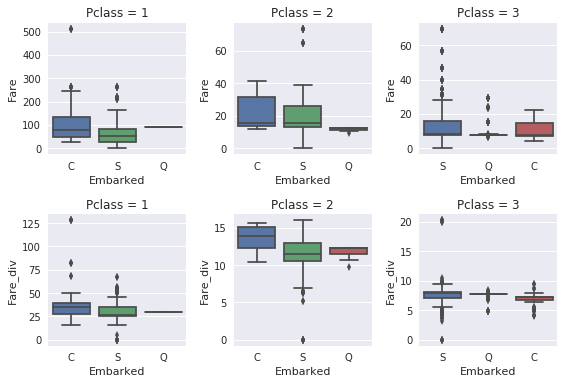

In [111]:
fig, ax = plt.subplots(2,3)
study_cont = ['Fare', 'Fare_div']
for j in range(len(study_cont)):
    for i in range(len(pc_unqiue)):
        fare_em_tmp = fare_em[fare_em['Pclass']==pc_unqiue[i]]
        sns.boxplot(x=fare_em_tmp['Embarked'], y=fare_em_tmp[study_cont[j]], ax=ax[j,i])
        ax[j,i].set_title('Pclass = {}'.format(pc_unqiue[i]))
plt.tight_layout()

Even after controlling Pclass and Embarked, there are still outliers in several of the fare distribution. This indicates that there are still uncontrolled factors influencing the fare. Let's look into the outliers to see if more processing needs to be performed on fare.

In [112]:
fare_em_1c = fare_em.loc[(fare_em['Pclass']==1)&(fare_em['Embarked']== 'C')]

In [113]:
# Calculate the threhold for outlier
Q1 = fare_em_1c['Fare_div'].quantile(0.25)
Q3 = fare_em_1c['Fare_div'].quantile(0.75)
IQR = Q3 - Q1

In [114]:
data_rd3_1c_out = data_rd3.loc[(data_rd3['Pclass']==1)&(data_rd3['Embarked']=='C')&(data_rd3['Fare_div']>Q3 + 1.5 * IQR)]

In [115]:
data_rd3_1c_out.sort_values(by='ticket_num2')

,Age,Cabin,Embarked,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Fare_div,occurance,Fare
1143,27.0,C89,C,0,1144,1,0,1,NaN,0,0,1,0,0,0,0.0,13508.0,68.389600,2.0,136.7792
1163,26.0,C89,C,0,1164,1,1,1,NaN,0,0,0,1,0,0,0.0,13508.0,68.389600,2.0,136.7792
118,24.0,B58 B60,C,1,119,1,0,0,0.0,0,0,1,0,0,0,0.0,17558.0,82.506933,3.0,247.5208
299,50.0,B58 B60,C,1,300,1,1,0,1.0,0,0,0,1,0,0,0.0,17558.0,82.506933,3.0,247.5208
1075,27.0,B58 B60,C,1,1076,1,1,1,NaN,0,0,0,1,0,0,0.0,17558.0,82.506933,3.0,247.5208
258,35.0,NaN,C,0,259,1,1,0,1.0,0,1,0,0,0,0,0.0,17755.0,128.082300,4.0,512.3292
679,36.0,B51 B53 B55,C,1,680,1,0,0,1.0,0,0,1,0,0,0,0.0,17755.0,128.082300,4.0,512.3292
737,35.0,B101,C,0,738,1,0,0,1.0,0,0,1,0,0,0,0.0,17755.0,128.082300,4.0,512.3292
1234,58.0,B51 B53 B55,C,1,1235,1,1,0,NaN,0,0,0,1,0,0,0.0,17755.0,128.082300,4.0,512.3292


From the above outlier analysis, it is hard to see any obvious complication that triggers the abonormal prices. We will keep the values as it is for now. It is also hard to see any obvious influence of embarked location of the fare. We will therefore drop the Embarked feature.

In [116]:
# Perform one hot encodeing for embarked
one_hot_embarked = pd.get_dummies(data_rd3['Embarked'], prefix='Embarked')
data_rd3 = data_rd3.join(one_hot_embarked)
data_rd3.drop('Embarked', axis=1, inplace=True)

In [141]:
data_rd4 = data_rd3.copy()
# data_rd4.drop('ticket_num2', axis=1, inplace=True)
# data_rd4.drop('Fare', axis=1, inplace=True)
# data_rd4.drop('SibSp', axis=1, inplace=True)
# data_rd4.drop('Parch', axis=1, inplace=True)
# data_rd4.drop('occurance', axis=1, inplace=True)

In [142]:
data_rd4.head()

,Age,Cabin,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,...,Officer,Royalty,ticket_num1,ticket_num2,Fare_div,occurance,Fare,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,0,1,3,0,1,0.0,0,0,...,0,0,5.0,21171.0,7.25000,1.0,7.2500,0,0,1
1,38.0,C85,0,2,1,1,1,1.0,0,0,...,0,0,0.0,17599.0,35.64165,2.0,71.2833,1,0,0
2,26.0,NaN,0,3,3,1,0,1.0,0,1,...,0,0,2.0,3101282.0,7.92500,1.0,7.9250,0,0,1
3,35.0,C123,0,4,1,1,1,1.0,0,0,...,0,0,0.0,113803.0,26.55000,2.0,53.1000,0,0,1
4,35.0,NaN,0,5,3,0,0,0.0,0,0,...,0,0,0.0,373450.0,8.05000,1.0,8.0500,0,0,1


In [ ]:
data_rd4.Cabin.fillna('U', inplace=True)
data_rd4['Cabin'] = data_rd4['Cabin'].map(lambda c : c[0])
one_hot_cabin = pd.get_dummies(data_rd4['Cabin'], prefix='Cabine')
data_rd4 = data_rd4.join(one_hot_cabin)
data_rd4.drop('Cabin', axis=1, inplace=True)

In [147]:
data_rd4.head()

,Age,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,...,Embarked_S,Cabine_A,Cabine_B,Cabine_C,Cabine_D,Cabine_E,Cabine_F,Cabine_G,Cabine_T,Cabine_U
0,22.0,0,1,3,0,1,0.0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,38.0,0,2,1,1,1,1.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,0,3,3,1,0,1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,4,1,1,1,1.0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,35.0,0,5,3,0,0,0.0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


Next, we need to make every effort we have to fill the nan values in Age. Name title could serve as an important information.

In [101]:
age_title = data_rd4.copy()
age_title.drop('Pclass', axis=1, inplace=True)
age_title.drop('Survived', axis=1, inplace=True)
age_title.drop('Fare_div', axis=1, inplace=True)
age_title.head()

,Age,Cabin,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num2,occurance,Fare
0,22.0,NaN,0,1,0,1,0,0,1,0,0,0,21171.0,1.0,7.2500
1,38.0,C85,0,2,1,1,0,0,0,1,0,0,17599.0,2.0,71.2833
2,26.0,NaN,0,3,1,0,0,1,0,0,0,0,3101282.0,1.0,7.9250
3,35.0,C123,0,4,1,1,0,0,0,1,0,0,113803.0,2.0,53.1000
4,35.0,NaN,0,5,0,0,0,0,1,0,0,0,373450.0,1.0,8.0500


We will fill the nan values in age from two perspective
1. From the distribution with the similar age and title information
2. From the parent of children roel in the family

We will do first use only the age and title informaiton
#### We will comback to the 2nd part later

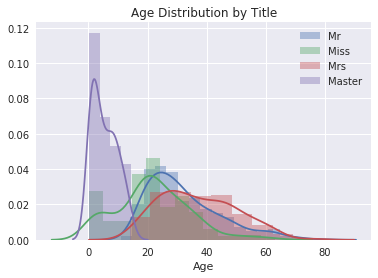

In [806]:
key_title = ['Mr','Miss','Mrs', 'Master']
for i in range(4):    # 4 different titles
    Age_group = age_title.loc[age_title[key_title[i]]==1].dropna()
    sns.distplot(Age_group['Age'], label=key_title[i])
    plt.title('Age Distribution by Title')
plt.legend()

From the distribution, we could see that we could use title to fill the nan value of master directly. However, for other title group, we need to seek for further constraint with Parch and SibSp.

In [807]:
# Fill nan age value of title Master group with the median
age_master = age_title.loc[age_title['Master']==1]
age_master.loc[np.isnan(age_master['Age'])]

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare
65,NaN,1,66,0,1,1,0,0,0,2661.0,3.0,15.2458
159,NaN,2,160,0,8,1,0,0,0,2343.0,11.0,69.5500
176,NaN,1,177,0,3,1,0,0,0,4133.0,5.0,25.4667
709,NaN,1,710,0,1,1,0,0,0,2661.0,3.0,15.2458
1135,NaN,2,1136,0,1,1,0,0,0,6607.0,4.0,23.4500
1230,NaN,0,1231,0,0,1,0,0,0,2622.0,1.0,7.2292
1235,NaN,1,1236,0,1,1,0,0,0,851.0,3.0,14.5000
1308,NaN,1,1309,0,1,1,0,0,0,2668.0,3.0,22.3583


In [808]:
master_median = age_master.median()
age_title.loc[age_title['Master']==1] = age_title.loc[age_title['Master']==1].fillna(master_median)

In [809]:
# Check the filling success
age_master = age_title.loc[age_title['Master']==1]
age_master.loc[np.isnan(age_master['Age'])]

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare


In [810]:
age_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1054 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
ticket_num2    1305 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
dtypes: float64(4), int64(4), uint8(4)
memory usage: 97.2 KB


In [811]:
# Get the title group Mr
age_mr = age_title.loc[age_title['Mr']==1]

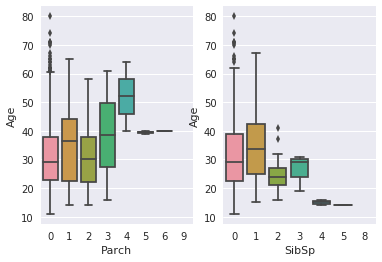

In [812]:
# Obtain the relationship between Parch, SibSp
fig, ax=plt.subplots(1,2)
sns.boxplot(x=age_mr['Parch'], y=age_mr['Age'], ax=ax[0])
sns.boxplot(x=age_mr['SibSp'], y=age_mr['Age'], ax=ax[1])

From the above plots we could see that for mr group, Parch > 3 or SipSp > 1 could be delt with directly. We need to look into the rest.
For the rest, we will consider that the exact age won't influence the survival and fill with the group median.
Keep the rest with nan and filled with xgboost algorithm 
### will be explored later

In [813]:
Age_mr_Parch= age_mr.Parch.unique()
Age_mr_SibSp = age_mr.SibSp.unique()

In [814]:
# Fill nan age value of title Mr group
age_mr = age_title.loc[age_title['Mr']==1]
age_mr.loc[np.isnan(age_mr['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare
5,NaN,0,6,0,0,0,0,1,0,330877.0,1.0,8.4583
17,NaN,0,18,0,0,0,0,1,0,244373.0,1.0,13.0000
26,NaN,0,27,0,0,0,0,1,0,2631.0,1.0,7.2250
29,NaN,0,30,0,0,0,0,1,0,349216.0,1.0,7.8958
36,NaN,0,37,0,0,0,0,1,0,2677.0,1.0,7.2292


In [815]:
# Fill nan age value of title Master group with the median
for i in range(len(Age_mr_Parch)):
    for j in range(len(Age_mr_SibSp)):
        if Age_mr_Parch[i]>4:
            Age_mr_fill = age_mr.loc[age_mr['Parch']>4, 'Age'].median()
            age_title.loc[(age_title['Mr']==1)&(age_title['Parch']==Age_mr_Parch[i])] =age_title.loc[(age_title['Mr']==1)&(age_title['Parch']==Age_mr_Parch[i])].fillna(Age_mr_fill)
        elif Age_mr_SibSp[j]>3:
            Age_mr_fill = age_mr.loc[age_mr['SibSp']>3, 'Age'].median()
            age_title.loc[(age_title['Mr']==1)&(age_title['SibSp']==Age_mr_SibSp[j])] =age_title.loc[(age_title['Mr']==1)&(age_title['SibSp']==Age_mr_SibSp[j])].fillna(Age_mr_fill)
        else:
            Age_mr_fill = age_mr.loc[(age_mr['SibSp']==Age_mr_SibSp[j])&(age_mr['Parch']==Age_mr_Parch[i]), 'Age'].median()
            age_title.loc[(age_title['Mr']==1)&(age_title['SibSp']==Age_mr_SibSp[j])&(age_title['Parch']==Age_mr_Parch[i])]=age_title.loc[(age_title['Mr']==1)&(age_title['SibSp']==Age_mr_SibSp[j])&(age_title['Parch']==Age_mr_Parch[i])].fillna(Age_mr_fill)

In [816]:
# Check the filling success
age_mr = age_title.loc[age_title['Mr']==1]
age_mr.loc[np.isnan(age_mr['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare


In [817]:
age_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1230 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
ticket_num2    1309 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
dtypes: float64(4), int64(4), uint8(4)
memory usage: 97.2 KB


In [818]:
# Get the title group Miss
age_miss = age_title.loc[age_title['Miss']==1]
age_miss.loc[np.isnan(age_miss['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare
28,NaN,0,29,1,0,0,1,0,0,330959.0,1.0,7.8792
32,NaN,0,33,1,0,0,1,0,0,335677.0,1.0,7.7500
47,NaN,0,48,1,0,0,1,0,0,14311.0,1.0,7.7500
82,NaN,0,83,1,0,0,1,0,0,330932.0,1.0,7.7875
109,NaN,0,110,1,1,0,1,0,0,371110.0,3.0,24.1500


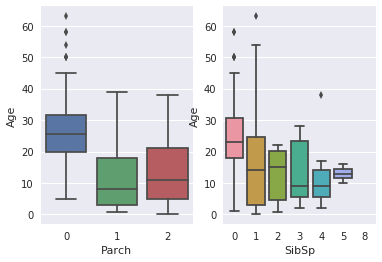

In [819]:
# Obtain the relationship between Parch, SibSp
fig, ax=plt.subplots(1,2)
sns.boxplot(x=age_miss['Parch'], y=age_miss['Age'], ax=ax[0])
sns.boxplot(x=age_miss['SibSp'], y=age_miss['Age'], ax=ax[1])

In [820]:
Age_miss_Parch= age_miss.Parch.unique()
Age_miss_SibSp = age_miss.SibSp.unique()

In [821]:
# Fill nan age value of title Miss group
age_miss = age_title.loc[age_title['Miss']==1]
age_miss.loc[np.isnan(age_miss['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare
28,NaN,0,29,1,0,0,1,0,0,330959.0,1.0,7.8792
32,NaN,0,33,1,0,0,1,0,0,335677.0,1.0,7.7500
47,NaN,0,48,1,0,0,1,0,0,14311.0,1.0,7.7500
82,NaN,0,83,1,0,0,1,0,0,330932.0,1.0,7.7875
109,NaN,0,110,1,1,0,1,0,0,371110.0,3.0,24.1500


In [822]:
# Fill nan age value of title Master group with the median
for i in range(len(Age_miss_Parch)):
    for j in range(len(Age_miss_SibSp)):
        if Age_miss_SibSp[j]<5:
            Age_miss_fill = age_miss.loc[(age_miss['SibSp']==Age_miss_SibSp[j])&(age_miss['Parch']==Age_miss_Parch[i]), 'Age'].median()
            age_title.loc[(age_title['Miss']==1)&(age_title['SibSp']==Age_miss_SibSp[j])&(age_title['Parch']==Age_miss_Parch[i])]=age_title.loc[(age_title['Miss']==1)&(age_title['SibSp']==Age_miss_SibSp[j])&(age_title['Parch']==Age_miss_Parch[i])].fillna(Age_miss_fill)
        else:
            Age_miss_fill = age_miss.loc[(age_miss['SibSp']>4)&(age_miss['Parch']==Age_miss_Parch[i]), 'Age'].median()
            age_title.loc[(age_title['Miss']==1)&(age_title['SibSp']==Age_miss_SibSp[j])&(age_title['Parch']==Age_miss_Parch[i])]=age_title.loc[(age_title['Miss']==1)&(age_title['SibSp']==Age_miss_SibSp[j])&(age_title['Parch']==Age_miss_Parch[i])].fillna(Age_miss_fill)

In [823]:
# Check the filling success
age_miss = age_title.loc[age_title['Miss']==1]
age_miss.loc[np.isnan(age_miss['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare


In [824]:
age_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1280 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
ticket_num2    1309 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
dtypes: float64(4), int64(4), uint8(4)
memory usage: 97.2 KB


In [825]:
# Get the title group Mrs
age_mrs = age_title.loc[age_title['Mrs']==1]
age_mrs.loc[np.isnan(age_mrs['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare
19,NaN,0,20,1,0,0,0,0,1,2649.0,1.0,7.2250
31,NaN,0,32,1,1,0,0,0,1,17569.0,3.0,146.5208
140,NaN,2,141,1,0,0,0,0,1,2678.0,3.0,15.2458
166,NaN,1,167,1,0,0,0,0,1,113505.0,2.0,55.0000
186,NaN,0,187,1,1,0,0,0,1,370365.0,2.0,15.5000


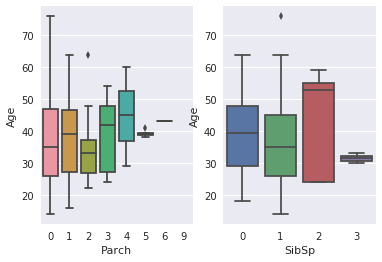

In [826]:
# Obtain the relationship between Parch, SibSp
fig, ax=plt.subplots(1,2)
sns.boxplot(x=age_mrs['Parch'], y=age_mrs['Age'], ax=ax[0])
sns.boxplot(x=age_mrs['SibSp'], y=age_mrs['Age'], ax=ax[1])

In [827]:
Age_mrs_Parch= age_mrs.Parch.unique()
Age_mrs_SibSp = age_mrs.SibSp.unique()

In [828]:
# Fill nan age value of title Master group with the median
for i in range(len(Age_mrs_Parch)):
    for j in range(len(Age_mrs_SibSp)):
        if Age_mrs_SibSp[j] == 3:
            Age_mrs_fill = age_mrs.loc[age_mrs['SibSp']==3, 'Age'].median()
            age_title.loc[(age_title['Mrs']==1)&(age_title['SibSp']==3)]=age_title.loc[(age_title['Mrs']==1)&(age_title['SibSp']==3)].fillna(Age_mrs_fill)
        elif Age_mrs_Parch[i]>4:
            Age_mrs_fill = age_mrs.loc[(age_mrs['Parch']>4), 'Age'].median()
            age_title.loc[(age_title['Mrs']==1)&(age_title['Parch']>4)]=age_title.loc[(age_title['Mrs']==1)&(age_title['Parch']>4)].fillna(Age_mrs_fill)
        else:
            Age_mrs_fill = age_mrs.loc[(age_mrs['SibSp']==Age_mrs_SibSp[j])&(age_mrs['Parch']==Age_mrs_Parch[i]), 'Age'].median()
            age_title.loc[(age_title['Mrs']==1)&(age_title['SibSp']==Age_mrs_SibSp[j])&(age_title['Parch']==Age_mrs_Parch[i])]=age_title.loc[(age_title['Mrs']==1)&(age_title['SibSp']==Age_mrs_SibSp[j])&(age_title['Parch']==Age_mrs_Parch[i])].fillna(Age_mrs_fill)

In [829]:
# Check the filling success
age_mrs = age_title.loc[age_title['Mrs']==1]
age_mrs.loc[np.isnan(age_mrs['Age'])]

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare


In [830]:
age_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1307 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
ticket_num2    1309 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
dtypes: float64(4), int64(4), uint8(4)
memory usage: 97.2 KB


In [831]:
# Get the title group others
age_title['others'] = age_title['Master'] + age_title['Mr'] + age_title['Miss'] + age_title['Mrs']
age_others = age_title.loc[age_title['others']==0]
age_others.loc[np.isnan(age_others['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare,others
766,NaN,0,767,0,0,0,0,0,0,112379.0,1.0,39.60,0
979,NaN,0,980,1,0,0,0,0,0,364856.0,1.0,7.75,0


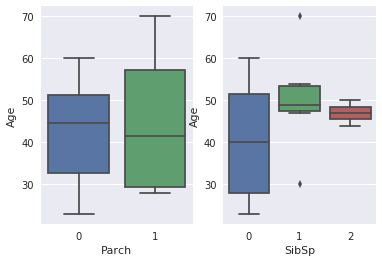

In [832]:
# Obtain the relationship between Parch, SibSp
fig, ax=plt.subplots(1,2)
sns.boxplot(x=age_others['Parch'], y=age_others['Age'], ax=ax[0])
sns.boxplot(x=age_others['SibSp'], y=age_others['Age'], ax=ax[1])

In [833]:
Age_others_Parch= age_others.Parch.unique()
Age_others_SibSp = age_others.SibSp.unique()

In [834]:
# Fill nan age value of title Master group with the median
for i in range(len(Age_others_Parch)):
    for j in range(len(Age_others_SibSp)):
        if Age_others_SibSp[j] == 1:
            Age_others_fill = age_others.loc[age_others['SibSp']==1, 'Age'].median()
            age_title.loc[(age_title['others']==0)&(age_title['SibSp']==1)]=age_title.loc[(age_title['others']==0)&(age_title['SibSp']==1)].fillna(Age_others_fill)
        elif Age_others_SibSp[j] == 2:
            Age_others_fill = age_others.loc[(age_others['SibSp']==2), 'Age'].median()
            age_title.loc[(age_title['others']==0)&(age_title['SibSp']==2)]=age_title.loc[(age_title['others']==0)&(age_title['SibSp']==2)].fillna(Age_others_fill)
        else:
            Age_others_fill = age_others.loc[(age_others['SibSp']==Age_others_SibSp[j])&(age_others['Parch']==Age_others_Parch[i]), 'Age'].median()
            age_title.loc[(age_title['others']==0)&(age_title['SibSp']==Age_others_SibSp[j])&(age_title['Parch']==Age_others_Parch[i])]=age_title.loc[(age_title['others']==0)&(age_title['SibSp']==Age_others_SibSp[j])&(age_title['Parch']==Age_others_Parch[i])].fillna(Age_others_fill)

In [835]:
age_others = age_title.loc[age_title['others']==0]
age_others.loc[np.isnan(age_others['Age'])].head()

,Age,Parch,PassengerId,Sex,SibSp,Master,Miss,Mr,Mrs,ticket_num2,occurance,Fare,others


In [836]:
age_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
ticket_num2    1309 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
others         1309 non-null uint8
dtypes: float64(4), int64(4), uint8(5)
memory usage: 98.4 KB


In [837]:
data_rd4.drop(labels='Age', axis=1, inplace=True)
data_rd4= data_rd4.join(age_title['Age'], how='outer')

In [1473]:
# Try first without filling in age
# data_rd4 = data_rd3.copy()
# data_rd4.drop(labels='Embarked', axis=1, inplace=True)
# data_rd4.drop('ticket_num1', axis=1, inplace=True)
# # data_rd4.drop('ticket_num2', axis=1, inplace=True)
# data_rd4.drop('Fare', axis=1, inplace=True)
# # data_rd4.drop('SibSp', axis=1, inplace=True)
# # data_rd4.drop('Parch', axis=1, inplace=True)
# # data_rd4.drop('occurance', axis=1, inplace=True)
data_rd5 = data_rd4.copy()
#data_rd5.drop(labels='Parch', axis=1, inplace=True)
#data_rd5.drop(labels='Master', axis=1, inplace=True)
#data_rd5.drop(labels='Mr', axis=1, inplace=True)
#data_rd5.drop(labels='Miss', axis=1, inplace=True)
#data_rd5.drop(labels='Mrs', axis=1, inplace=True)
#data_rd5.drop(labels='SibSp', axis=1, inplace=True)
data_rd5.drop(labels='ticket_num2', axis=1, inplace=True)

In [1474]:
# Perform one hot encoding on Pclass
# one_hot_pclass =pd.get_dummies(data_rd5['Pclass'],prefix='Pclass')
# data_rd5=data_rd5.join(one_hot_pclass, how='outer')
# data_rd5.drop('Pclass_2', axis=1, inplace=True)
# data_rd5.drop('Pclass', axis=1, inplace=True)
data_rd5.head()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
0,0,1,3,0,1,0.0,0,0,1,0,7.25000,1.0,7.2500,22.0
1,0,2,1,1,1,1.0,0,0,0,1,35.64165,2.0,71.2833,38.0
2,0,3,3,1,0,1.0,0,1,0,0,7.92500,1.0,7.9250,26.0
3,0,4,1,1,1,1.0,0,0,0,1,26.55000,2.0,53.1000,35.0
4,0,5,3,0,0,0.0,0,0,1,0,8.05000,1.0,8.0500,35.0


In [1475]:
data_rd5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
Fare_div       1309 non-null float64
occurance      1309 non-null float64
Fare           1309 non-null float64
Age            1309 non-null float64
dtypes: float64(5), int64(5), uint8(4)
memory usage: 117.6 KB


In [1476]:
from sklearn.model_selection import train_test_split

train_data = data_rd5[data_rd5['PassengerId']<892]
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [1477]:
print(sorted(Counter(y_train).items()))

[(0.0, 494), (1.0, 307)]


In [1478]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
train_data1 = pd.DataFrame(X_resampled.astype(int), columns=data_rd5.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd5.columns)
print(sorted(Counter(y_resampled).items()))
# train_data1 = X_train
# vali_data1 = X_vali

[(0.0, 494), (1.0, 494)]


In [1479]:
train_data1[np.isnan(train_data1['Mr'])]

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age


In [1480]:
train_keep = train_data1.copy()
vali_keep = vali_data1.copy()
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
# train_data1.drop('SibSp', axis=1, inplace=True)
# train_data1.drop('Parch', axis=1, inplace=True)
train_data1.drop('Fare', axis=1, inplace=True)
# train_data1.drop('occurance', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)
# vali_data1.drop('SibSp', axis=1, inplace=True)
# vali_data1.drop('Parch', axis=1, inplace=True)
vali_data1.drop('Fare', axis=1, inplace=True)
# vali_data1.drop('occurance', axis=1, inplace=True)

cv_score:0.8402494331065761
XGB classifier training accuracy:0.888663967611336


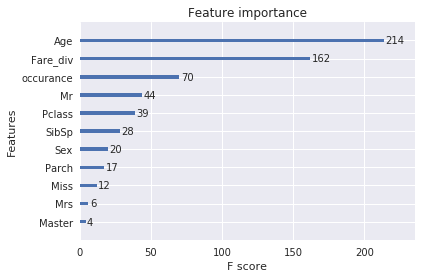

In [1481]:
XGB_clf = XGBClassifier()

from sklearn.model_selection import cross_validate
XGB_clf = XGBClassifier()
cv_score = cross_validation.cross_val_score(XGB_clf, train_data1, train_target1, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data1, train_target1)
XGB_predict1 = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict1, train_target1)))

plot_importance(XGB_clf)
plt.show()

From the preliminary results with can see that even letting XGBboost to fill in nan by itself. The training error is still high. We therefore needs to perform error analysis.

In [1694]:
test_data = data_rd5[data_rd5['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
#test_data.drop('SibSp', axis=1, inplace=True)
#test_data.drop('Parch', axis=1, inplace=True)
test_data.drop('Fare', axis=1, inplace=True)
rf_test_predict = XGB_clf.predict(test_data)
#list(rf_test_predict)

In [1716]:
pred_data1 = pd.Series(XGB_predict1, index=train_data1.index, name='Pred')
train_data1 = train_data1.join(pred_data1, how='outer')
train_data1 = train_data1.join(train_target1, how='outer')
#train_data1 = train_data1.join(train_keep['SibSp'], how='outer')
#train_data1 = train_data1.join(train_keep['Parch'], how='outer')

In [1717]:
# Identify the mistakenly identified
fn = train_data1[train_data1['Pred'] - train_data1['Survived'] < 0]
tp = train_data1[(train_data1['Pred'] == 1.0)&(train_data1['Survived']==1.0)]
# Identify the mistakenly identified
fp = train_data1[train_data1['Pred'] - train_data1['Survived'] > 0]
tn = train_data1[(train_data1['Pred'] == 0.0)&(train_data1['Survived']==0.0)]

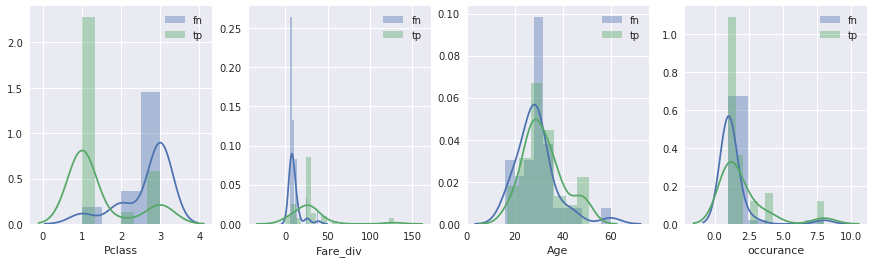

In [1718]:
# Compare the false negative and true positive
fig, ax = plt.subplots(1,4)
fig.set_figwidth(15)
sns.distplot(fn.loc[(fn['Mr']==1),'Pclass'], label='fn', ax=ax[0])
sns.distplot(tp.loc[(tp['Mr']==1),'Pclass'], label='tp', ax=ax[0])
sns.distplot(fn.loc[(fn['Mr']==1),'Fare_div'], label='fn',ax=ax[1])
sns.distplot(tp.loc[(tp['Mr']==1),'Fare_div'], label='tp',ax=ax[1])
sns.distplot(fn.loc[(fn['Mr']==1),'Age'], label='fn',ax=ax[2])
sns.distplot(tp.loc[(tp['Mr']==1),'Age'], label='tp',ax=ax[2])
sns.distplot(fn.loc[(fn['Mr']==1),'occurance'], label='fn',ax=ax[3])
sns.distplot(tp.loc[(tp['Mr']==1),'occurance'], label='tp',ax=ax[3])
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

From the above error analysis we can see that majority of the false negative comes from title = Mr with Pclass>1 and Fare_div < 25. We could do two things:
1. Create more training cases for this category
2. Engineer features to deal with the difference

In [1719]:
train_data = data_rd5[data_rd5['PassengerId']<892]
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [1605]:
train_data.describe()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.381594,446.000000,2.308642,0.352413,0.523008,0.383838,0.044893,0.204265,0.580247,0.140292,14.656063,2.098765,32.204208,29.133749
std,0.806057,257.353842,0.836071,0.477990,1.102743,0.486592,0.207186,0.403390,0.493796,0.347485,13.698940,1.795534,49.693429,13.380245
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.420000
25%,0.000000,223.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.550000,1.000000,7.910400,22.000000
50%,0.000000,446.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.050000,1.000000,14.454200,28.250000
75%,0.000000,668.500000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,13.861450,2.500000,31.000000,35.500000
max,6.000000,891.000000,3.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,128.082300,11.000000,512.329200,80.000000


In [1606]:
print(sorted(Counter(y_train).items()))

[(0.0, 494), (1.0, 307)]


In [1629]:
train_data_boost = train_data[(train_data['Fare_div']<8)&(train_data['Pclass']>1)]

In [1630]:
train_data2 = train_data.append(train_data_boost)

In [1631]:
train_data2.describe()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.00000,1278.000000,1278.000000,1278.00000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,0.422535,446.209703,2.502347,0.342723,0.58529,0.352895,0.055556,0.21205,0.586072,0.125196,12.272050,2.172144,26.825677,27.746354
std,0.867869,259.507750,0.767127,0.474806,1.24337,0.478058,0.229151,0.40892,0.492729,0.331070,12.025868,1.958082,42.887435,13.148543
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.420000
25%,0.000000,217.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,7.225000,1.000000,7.796850,21.000000
50%,0.000000,443.500000,3.000000,0.000000,0.00000,0.000000,0.000000,0.00000,1.000000,0.000000,7.854200,1.000000,13.000000,28.250000
75%,1.000000,671.750000,3.000000,1.000000,1.00000,1.000000,0.000000,0.00000,1.000000,0.000000,11.000000,3.000000,27.720800,33.000000
max,6.000000,891.000000,3.000000,1.000000,8.00000,1.000000,1.000000,1.00000,1.000000,1.000000,128.082300,11.000000,512.329200,80.000000


In [1632]:
train_keep = train_data2.copy()
vali_keep = X_vali.copy()
vali_data2 = X_vali.copy()
train_data2.drop('PassengerId', axis=1, inplace=True)
vali_data2.drop('PassengerId', axis=1, inplace=True)
train_target2 = train_data2['Survived']
vali_target2 = vali_data2['Survived']
train_data2.drop('Survived', axis=1, inplace=True)
# train_data1.drop('SibSp', axis=1, inplace=True)
# train_data1.drop('Parch', axis=1, inplace=True)
train_data2.drop('Fare', axis=1, inplace=True)
# train_data1.drop('occurance', axis=1, inplace=True)
vali_data2.drop('Survived', axis=1, inplace=True)
# vali_data1.drop('SibSp', axis=1, inplace=True)
# vali_data1.drop('Parch', axis=1, inplace=True)
vali_data2.drop('Fare', axis=1, inplace=True)
# vali_data1.drop('occurance', axis=1, inplace=True)

cv_score:0.908498106927596
XGB classifier training accuracy:0.9827856025039123


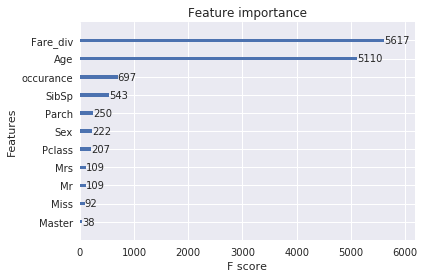

In [1633]:
XGB_clf = XGBClassifier(n_estimators=300, max_depth=60, min_child_weight=1)
cv_score = cross_validation.cross_val_score(XGB_clf, train_data2, train_target2, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data2, train_target2)
XGB_predict2 = XGB_clf.predict(train_data2)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict2, train_target2)))

plot_importance(XGB_clf)
plt.show()

In [1634]:
pred_data2 = pd.Series(XGB_predict2, index=train_data2.index, name='Pred')
train_data2 = train_data2.join(pred_data2, how='outer')
train_data2 = train_data2.join(train_target2, how='outer')

In [1635]:
# Identify the mistakenly identified
fn = train_data2[train_data2['Pred'] - train_data2['Survived'] < 0]
tp = train_data2[(train_data2['Pred'] == 1.0)&(train_data2['Survived']==1.0)]
# Identify the mistakenly identified
fp = train_data2[train_data2['Pred'] - train_data2['Survived'] > 0]
tn = train_data2[(train_data2['Pred'] == 0.0)&(train_data2['Survived']==0.0)]

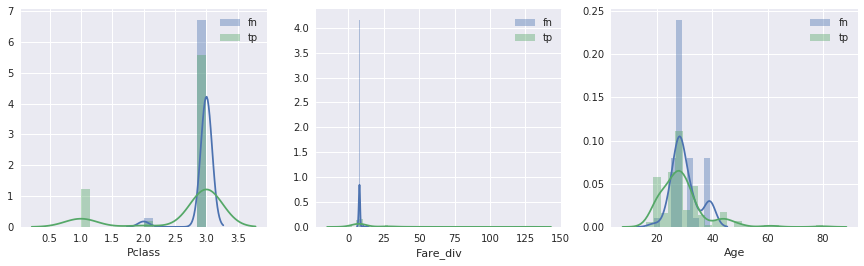

In [1636]:
# Compare the false negative and true positive
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
sns.distplot(fn.loc[(fn['Mr']==1),'Pclass'], label='fn', ax=ax[0])
sns.distplot(tp.loc[(tp['Mr']==1),'Pclass'], label='tp', ax=ax[0])
sns.distplot(fn.loc[(fn['Mr']==1),'Fare_div'], label='fn',ax=ax[1])
sns.distplot(tp.loc[(tp['Mr']==1),'Fare_div'], label='tp',ax=ax[1])
sns.distplot(fn.loc[(fn['Mr']==1),'Age'], label='fn',ax=ax[2])
sns.distplot(tp.loc[(tp['Mr']==1),'Age'], label='tp',ax=ax[2])
ax[0].legend()
ax[1].legend()
ax[2].legend()

From the above result, adding more samples of the training interest will create bias overfitting. We will try engineer feature for target training data.

In [1644]:
test_data = data_rd5[data_rd5['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
#test_data.drop('SibSp', axis=1, inplace=True)
#test_data.drop('Parch', axis=1, inplace=True)
test_data.drop('Fare', axis=1, inplace=True)
rf_test_predict = XGB_clf.predict(test_data)
# list(rf_test_predict)

In [1731]:
train_data = data_rd5[data_rd5['PassengerId']<892]
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15)&(train_data['Fare']<1)]

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
179,0,180,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,36.00
263,0,264,1,0,0,0.0,0,0,1,0,0.0,1.0,0.0,40.00
271,0,272,3,0,0,1.0,0,0,1,0,0.0,1.0,0.0,25.00
277,0,278,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
302,0,303,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,19.00
413,0,414,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
466,0,467,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
481,0,482,2,0,0,0.0,0,0,1,0,0.0,1.0,0.0,28.25
597,0,598,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,49.00
633,0,634,1,0,0,0.0,0,0,1,0,0.0,1.0,0.0,28.25


In [1726]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare']

179     0.0000
263     0.0000
271     0.0000
277     0.0000
302     0.0000
378    12.0375
413     0.0000
466     0.0000
481     0.0000
597     0.0000
633     0.0000
674     0.0000
732     0.0000
806     0.0000
815     0.0000
Name: Fare, dtype: float64

In [1724]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'] = train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'] * 3
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

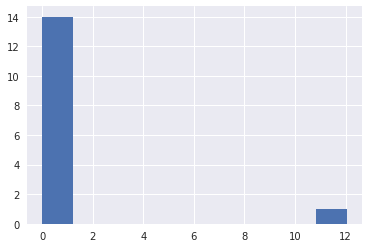

In [1725]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'].hist()

In [1713]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
train_data1 = pd.DataFrame(X_resampled.astype(int)+1, columns=data_rd5.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd5.columns)
print(sorted(Counter(y_resampled).items()))
# train_data1 = X_train
# vali_data1 = X_vali

[(0.0, 494), (1.0, 494)]


In [1714]:
train_keep = train_data1.copy()
vali_keep = vali_data1.copy()
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
# train_data1.drop('SibSp', axis=1, inplace=True)
# train_data1.drop('Parch', axis=1, inplace=True)
train_data1.drop('Fare', axis=1, inplace=True)
# train_data1.drop('occurance', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)
# vali_data1.drop('SibSp', axis=1, inplace=True)
# vali_data1.drop('Parch', axis=1, inplace=True)
vali_data1.drop('Fare', axis=1, inplace=True)
# vali_data1.drop('occurance', axis=1, inplace=True)

cv_score:0.842238713667285
XGB classifier training accuracy:0.9453441295546559


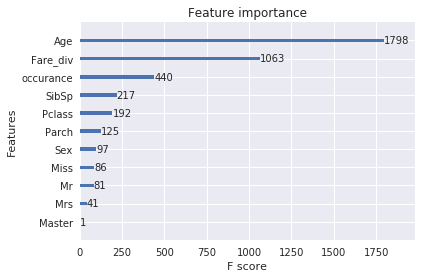

In [1715]:
XGB_clf = XGBClassifier(n_estimators=80, max_depth=20, min_child_weight=1)
cv_score = cross_validation.cross_val_score(XGB_clf, train_data1, train_target1, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data1, train_target1)
XGB_predict1 = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict1, train_target1)))

plot_importance(XGB_clf)
plt.show()

In [1640]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(train_data1, train_target1)

lr_predict = lr_clf.predict(train_data1)
print('Logistic regression classifier training accuracy:{}'.format(accuracy_score(lr_predict, train_target1)))

lr_predict = lr_clf.predict(vali_data1)
print('Logistic regression classifier validation accuracy:{}'.format(accuracy_score(lr_predict, vali_target1)))

Logistic regression classifier training accuracy:1.0


ValueError: X has 11 features per sample; expecting 13

In [ ]:
# Split into train and validation set
#train_data1_part1 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']<15)].sample(frac=0.5, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1_part2 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']>15)].sample(frac=1, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1 = pd.concat([train_data1_part1, train_data1_part2])
from sklearn.model_selection import train_test_split

train_data = data_rd1[data_rd1['PassengerId']<892]
train_data = train_data.dropna(axis=0, how='any')
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [ ]:
print(sorted(Counter(y_train).items()))

In [ ]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
train_data1 = pd.DataFrame(X_resampled, columns=data_rd1.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd1.columns)
print(sorted(Counter(y_resampled).items()))
# train_data1 = X_train
# vali_data1 = X_vali

In [ ]:
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)

In [ ]:
XGB_clf = XGBClassifier()
XGB_clf.fit(train_data1, train_target1)

plot_importance(XGB_clf)
plt.show()

XGB_predict = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict, train_target1)))

XGB_predict = XGB_clf.predict(vali_data1)
print('XGB classifier validation accuracy:{}'.format(accuracy_score(XGB_predict, vali_target1)))

In [ ]:
test_data.info()

In [ ]:
test_data = data_rd1[data_rd1['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
xgb_test_predict = XGB_clf.predict(test_data)
list(xgb_test_predict)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(train_data1, train_target1)

rf_predict = rf_clf.predict(train_data1)
print('RF classifier training accuracy:{}'.format(accuracy_score(rf_predict, train_target1)))

rf_predict = rf_clf.predict(vali_data1)
print('RF classifier validation accuracy:{}'.format(accuracy_score(rf_predict, vali_target1)))

In [ ]:
rf_test_predict = rf_clf.predict(test_data)
list(rf_test_predict)

In [ ]:
def modelfit(alg, dtrain, targets, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, targets)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain, targets, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(targets, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plot_importance(XGB_clf)
        plt.show()

In [ ]:
param_test1 = {
 'n_estimators':range(85,95,1),
 'max_depth':range(6,8,1),
 'min_child_weight':range(2,4,1)
}

estimator1 = XGBClassifier( learning_rate =0.1, n_estimators=90, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
vali_data1.info()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

In [ ]:
# # Perform hyperparameter search for gradient boosting classifier
# gb_clf = GradientBoostingClassifier()
# param_grid=[{'learning_rate':[0.05, 0.1], 'n_estimators':[50, 100, 200], 'max_depth':[2,5,10], 'max_features' : [2,4,6,8]},]
# gb_clf = GradientBoostingClassifier()

# grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(train_data1, train_target1)
# print(grid_search.best_params_, grid_search.best_score_)

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

XGB_clf = XGBClassifier()
XGB_clf.fit(train_data1, train_target1)

plot_importance(XGB_clf)
plt.show()


XGB_predict = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(f1_score(XGB_predict, train_target1)))

### Perform hyperparameter search on XGB classifier 

In [ ]:
from sklearn import metrics
from sklearn import cross_validation

def modelfit(alg, dtrain, targets, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, targets)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain, targets, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(targets, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plot_importance(XGB_clf)
        plt.show()

In [ ]:
param_test1 = {
 'n_estimators':range(90,180,10),
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'n_estimators':range(165,175,1),
 'max_depth':range(8,10,1),
 #'min_child_weight':range(2,4,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=3,
 min_child_weight=5,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_data1, train_target1)

In [ ]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'reg_alpha':[1e-5, 5e-5, 1e-4,]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=169,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=1e-5,
 seed=27)
modelfit(xgb2, train_data1, train_target1)

In [ ]:
# Analyze the mistake made by the model
from sklearn.metrics import confusion_matrix
xgb2.fit(train_data1, train_target1)
xgb_predict = xgb2.predict(train_data1)
confusion_matrix(train_target1, xgb_predict)

In [ ]:
xgb_predict_vali = xgb2.predict(vali_data1)
accuracy_score(vali_target1, xgb_predict_vali)
confusion_matrix(vali_target1, xgb_predict_vali)

In [ ]:
test_data = data_rd1[data_rd1['PassengerId']>892]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
xgb_test_predict = xgb2.predict(test_data)
list(xgb_test_predict)

From the confusion matrix, we could see that more true false negative case were classfied (63). This might due to the imbalance of the training data size. 

In [ ]:
# Try using KNN to vote for the label
train_data1_reduced =  pd.concat([train_data1['Norm_fare'], train_data1['Age'], train_data1['Group_size'], train_data1['Sex'], train_data1['Pclass']], axis=1, keys=['Norm_fare', 'Age', 'Group_size', 'Sex', 'Pclass'])
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data1_scaled = scaler.fit_transform(train_data1_reduced)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
param_grid={'n_neighbors': np.arange(3,7,1),}
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')

grid_search.fit(train_data1_scaled, train_target1)
print(grid_search.best_params_, grid_search.best_score_)

In [ ]:
from sklearn.neural_network import MLPClassifier

MLP_clf = MLPClassifier(solver='lbfgs', alpha=2e-4, hidden_layer_sizes=(7, 3), random_state=1)

MLP_clf.fit(train_data1_scaled, train_target1)

In [ ]:
train_predict=MLP_clf.predict(train_data1_scaled)

accuracy_score(train_predict, train_target1)

In [ ]:
# Perform cross validation on MLP

